In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np

annFile = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/val_combined.json"
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=3.50s)
creating index...
index created!


In [2]:
category = "person"
catIds = coco.getCatIds(catNms=[category])
imgIds = coco.getImgIds(catIds=catIds )
print(len(imgIds))

3230


In [3]:
def show_bbox (image, bbox_list):
    show_img = np.copy(image)
    for bbox in bbox_list:
        [x1,y1,x2,y2] = bbox 
        cv2.rectangle(show_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 5)
    plt.imshow(show_img)
    plt.show()

In [7]:
def show_polygon(image, polygons):
    show_image = np.copy(image)
    cv2.polylines(show_image, polygons, True, (0,255,0), thickness=3)
    plt.imshow(show_image)
    plt.show()
# np.int32([polygons_transformed[0]])

In [5]:
def get_boxes_and_polygons(anns):
    bboxes = []
    polys = []
    for ann in anns:
        bbox = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][0]+ann["bbox"][2], ann["bbox"][1]+ann["bbox"][3]]
        bboxes.append(bbox)

        poly_img = ann["segmentation"]
        for poly in poly_img:
            poly = np.reshape(poly, (-1,2))
            polys.append(np.int32(poly)) 
    return bboxes, polys 

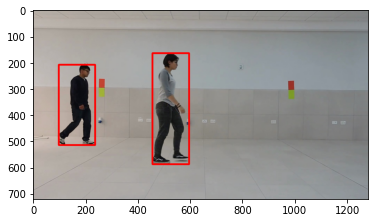

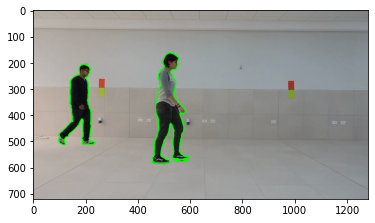

In [99]:
dir_path = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/images"
coco_img = coco.loadImgs(imgIds[0])[0]

img_name = coco_img["file_name"]
img_dir = os.path.join(dir_path, img_name)

annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
coco_anns = coco.loadAnns(annIds)

image = cv2.imread(img_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, polygons = get_boxes_and_polygons(coco_anns)
show_bbox(image, bboxes)
show_polygon(image, polygons)


In [7]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
    T.RandomCrop("absolute", (640, 640))
])  # type: T.Augmentation

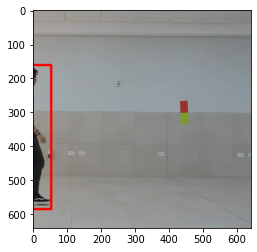

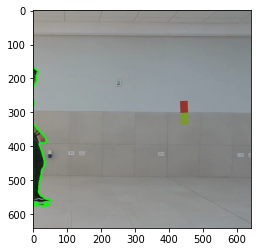

In [100]:
# Define the augmentation input ("image" required, others optional):
input = T.AugInput(image, boxes=bboxes)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = np.array(input.image)  # new image
boxes_transformed = input.boxes  # new semantic segmentation
polygons_copy = np.copy(polygons)
polygons_transformed = transform.apply_polygons(polygons_copy)
new_poly = [np.int32(p) for p in polygons_transformed]
show_bbox(image_transformed, boxes_transformed)
show_polygon(image_transformed, new_poly)


## Albumentations

### Functions to find masks and bboxes

In [1]:
def get_boxes_and_masks_coco(anns,coco):
    bboxes = []
    masks = []
    for ann in anns:
        bboxes.append(ann["bbox"])
        masks.append(coco.annToMask(ann)) 
    return bboxes, masks

In [2]:
def show_bbox_coco(image, bbox_list):
    show_img = np.copy(image)
    for bbox in bbox_list:
        [x,y,w,h] = bbox 
        cv2.rectangle(show_img, (int(x), int(y)), (int(x+w), int(y+h)), (255,0,0), 5)
    plt.imshow(show_img)
    plt.show()

In [3]:
def show_polygon(image, polygons):
    show_image = np.copy(image)
    cv2.polylines(show_image, polygons, True, (0,255,0), thickness=3)
    plt.imshow(show_image)
    plt.show()
# np.int32([polygons_transformed[0]])

### Functions to create polygon annotations

In [4]:
def mask_by_color(img, color):    
    mask = img == color
    return np.all(mask,axis = -1)

In [5]:
def create_submasks(img,colors):
    submasks = []
    black = np.array([0,0,0])
    colors = colors[~(colors==black).all(axis=1),:]
    for color in colors:
        submasks.append(mask_by_color(img,color))
    return submasks

In [6]:
def unique_row_view(data):
    b = np.ascontiguousarray(data).view(
        np.dtype((np.void, data.dtype.itemsize * data.shape[1]))
    )
    u = np.unique(b).view(data.dtype).reshape(-1, data.shape[1])
    return u

In [7]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

In [8]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure

def mask_to_annotation(in_mask, img_id, img_cat, ann_id, is_crowd):
    ground_truth_binary_mask = in_mask
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
    ground_truth_area = mask.area(encoded_ground_truth)
    ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)

    padded_binary_mask = np.pad(ground_truth_binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)

    polygons =[]
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, 0)   #tolerance = 0
        if len(contour) < 3:
            continue

        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)
    
    annotation = {
            "segmentation": polygons,
            "area": ground_truth_area.tolist(),
            "iscrowd": is_crowd,
            "image_id": img_id,
            "bbox": ground_truth_bounding_box.tolist(),
            "category_id": img_cat,
            "id": ann_id
        }
    
    return annotation

### Main program

In [9]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np

annFile = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/mixed_ucb_val.json"
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.03s)
creating index...
index created!


In [10]:
category = "person"
catIds = coco.getCatIds(catNms=[category])
imgIds = coco.getImgIds(catIds=catIds )
print(len(imgIds))

2000


In [11]:
import albumentations as A
import cv2

transform = A.Compose([
    # A.RandomCrop(width=450, height=450),
    A.CropNonEmptyMaskIfExists(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

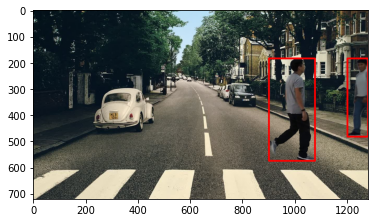

In [12]:
dir_path = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/images"
coco_img = coco.loadImgs(imgIds[1])[0]

img_name = coco_img["file_name"]
img_dir = os.path.join(dir_path, img_name)

annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
coco_anns = coco.loadAnns(annIds)

image = cv2.imread(img_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, masks = get_boxes_and_masks_coco(coco_anns,coco)
show_bbox_coco(image, bboxes)

The cell below takes 4.41 ms ± 64.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [13]:
transformed = transform(image=image,bboxes=bboxes,class_labels = ['cat', 'dog'],mask=masks[0], masks = masks)
t_image = transformed["image"]
t_bboxes = transformed["bboxes"]
t_labels = transformed["class_labels"]

t_masks = transformed["masks"]
t_masks = [mask for mask in t_masks if cv2.countNonZero(mask)!=0]

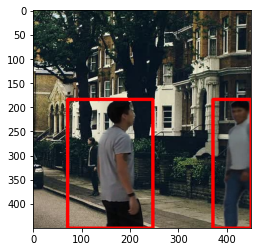

In [14]:
plt.imshow(t_image)
show_bbox_coco(t_image,t_bboxes)


The cell below takes 5.9 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [15]:

img_license = 0
img_id=0
ann_id=0
is_crowd=0
img_cat = 1
images=[]
annotations = []

for submask in t_masks:
    annotation = mask_to_annotation(submask , img_id, img_cat, ann_id, is_crowd)
    annotations.append(annotation)
    ann_id+=1

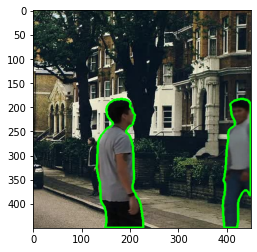

In [16]:
polys = []
for ann in annotations:
    poly_img = ann["segmentation"]
    for poly in poly_img:
        poly = np.reshape(poly, (-1,2))
        polys.append(np.int32(poly)) 
show_polygon(t_image,polys)